In [1]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/kaggle/input/text-emotion-recognition/Text_Emotion.csv')
df.head()

,text,emotion
0,carefully word blog posts amount criticism hea...,☹️
1,cannot remember little mermaid feeling carefre...,🙂
2,not feeling super well turns cold knocked next...,🙂
3,feel honored part group amazing talents,🙂
4,think helping also began feel pretty lonely lo...,☹️


In [4]:
#Cleaning the emojis with mapping
df['emotion'] = df['emotion'].map({
    '☹️' : 0,
    '🙂' : 1
})

df.head()

,text,emotion
0,carefully word blog posts amount criticism hea...,0
1,cannot remember little mermaid feeling carefre...,1
2,not feeling super well turns cold knocked next...,1
3,feel honored part group amazing talents,1
4,think helping also began feel pretty lonely lo...,0


In [5]:
#Lower case if there is any
df['text'] = df['text'].apply(lambda x: x.lower())
df.head()

,text,emotion
0,carefully word blog posts amount criticism hea...,0
1,cannot remember little mermaid feeling carefre...,1
2,not feeling super well turns cold knocked next...,1
3,feel honored part group amazing talents,1
4,think helping also began feel pretty lonely lo...,0


In [6]:
#Import NLTK for stop words
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
from string import punctuation

def remove_stopwords_and_punctuations(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words and token not in punctuation]
    return ' '.join(filtered_tokens)

df['text'] = df['text'].apply(lambda x: remove_stopwords_and_punctuations(x))
df.head()

,text,emotion
0,carefully word blog posts amount criticism hea...,0
1,remember little mermaid feeling carefree beaut...,1
2,feeling super well turns cold knocked next thr...,1
3,feel honored part group amazing talents,1
4,think helping also began feel pretty lonely lo...,0


In [8]:
#Shuffle
from sklearn.utils import shuffle

df = shuffle(df)
df.head()

,text,emotion
124415,feel relieved sad time,1
280623,really double time works update blog soon show...,1
275986,glad longer feel doomed single old lady,0
133887,feel bit vain uploading,0
10683,take kid golden arches feel though wear fake m...,0


In [9]:
#Train-Test Split
from sklearn.model_selection import train_test_split

labels = df['emotion']
data = df['text']

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)

x_train.head()

253830    lip service faith fine feel markedly air resul...
150496    never felt confident telling people jesus alwa...
214144    yeah things going well getting feel like felt ...
215105    learned truly love unconditionally compassiona...
169753    feel like throwing target blank title heartbur...
Name: text, dtype: object

In [10]:
#Tokenization & sequencing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)

sequence_train = tokenizer.texts_to_sequences(x_train)
sequence_test = tokenizer.texts_to_sequences(x_test)

In [11]:
V = len(tokenizer.index_word)
print("Tokenized %s Unique Tokens" %V)

Tokenized 63475 Unique Tokens


In [12]:
#Padding
data_train = pad_sequences(sequence_train)

T = data_train.shape[1]

data_test = pad_sequences(sequence_test, maxlen=T)

In [13]:
#Build Model
from tensorflow.keras.layers import Input, Conv1D, Embedding, MaxPooling1D, GlobalMaxPooling1D, Add, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Model

D = 20

i = Input(shape=(T,))
x = Embedding(V + 1 , D)(i)
x = Conv1D(32, 3, padding='same',activation=LeakyReLU(alpha=0.2))(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, padding='same', activation=LeakyReLU(alpha=0.2))(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, padding='same', activation=LeakyReLU(alpha=0.2))(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)


In [14]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss = 'binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam(
        learning_rate=0.0002
    )
)

In [15]:
r = model.fit(
    data_train,
    y_train,
    validation_data=(data_test, y_test),
    epochs = 50
)

Epoch 1/50
5922/5922 [==============================] - 83s 12ms/step - loss: 0.1512 - accuracy: 0.9251 - val_loss: 0.0728 - val_accuracy: 0.9674
Epoch 2/50
5922/5922 [==============================] - 46s 8ms/step - loss: 0.0609 - accuracy: 0.9753 - val_loss: 0.0686 - val_accuracy: 0.9700
Epoch 3/50
5922/5922 [==============================] - 46s 8ms/step - loss: 0.0493 - accuracy: 0.9803 - val_loss: 0.0742 - val_accuracy: 0.9688
Epoch 4/50
5922/5922 [==============================] - 43s 7ms/step - loss: 0.0401 - accuracy: 0.9843 - val_loss: 0.0809 - val_accuracy: 0.9675
Epoch 5/50
5922/5922 [==============================] - 46s 8ms/step - loss: 0.0319 - accuracy: 0.9877 - val_loss: 0.0929 - val_accuracy: 0.9665
Epoch 6/50
5922/5922 [==============================] - 46s 8ms/step - loss: 0.0247 - accuracy: 0.9905 - val_loss: 0.1026 - val_accuracy: 0.9654
Epoch 7/50
5922/5922 [==============================] - 43s 7ms/step - loss: 0.0193 - accuracy: 0.9930 - val_loss: 0.1305 - val_a

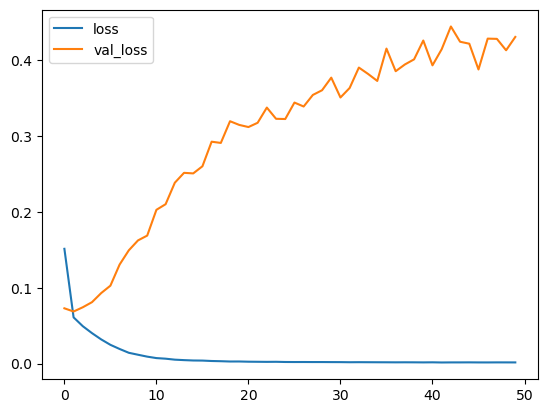

In [16]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

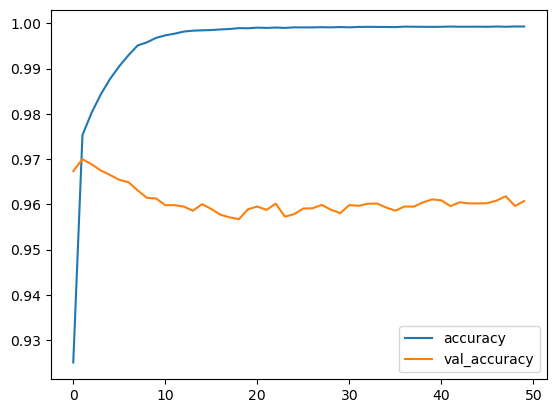

In [17]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()

In [18]:
model.evaluate(
    data_test,
    y_test
)

2917/2917 [==============================] - 8s 3ms/step - loss: 0.4303 - accuracy: 0.9607


[0.4302615225315094, 0.9607422947883606]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


(-0.5, 491.5, 1068.5, -0.5)

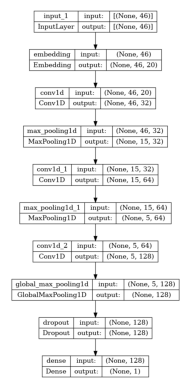

In [19]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import save_model
import imageio

save_model(model, 'emotion-recoginition.h5')
plot_model(model, to_file='/kaggle/working/architecture.png', show_shapes=True)

plt.imshow(imageio.imread('/kaggle/working/architecture.png'))
plt.axis('off')

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 46)]              0         
                                                                 
 embedding (Embedding)       (None, 46, 20)            1269520   
                                                                 
 conv1d (Conv1D)             (None, 46, 32)            1952      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 64)            0         
 1D)                                                         